In [7]:
# import sigpy as sp
import os
import torch
import matplotlib.pyplot as plt
import h5py
import numpy as np
import glob
from tqdm import tqdm

# Grab the file list

In [9]:
data_root = "/csiNAS2/slow/brett/single_coil_fastmri_data/brain/"

file_list = glob.glob(os.path.join(data_root, "*.h5"))
print(len(file_list))
print(file_list[0])

# hf = h5py.File(file_list[0], 'r')
# mvue_vol = np.asarray(hf['gt_imgs'])
# norm_maxes = np.max(abs(mvue_vol),axis=(-2,-1))[:,None,None]
# normalized_vol = mvue_vol / norm_maxes
# two_channel_img = np.stack((normalized_vol.real, normalized_vol.imag), axis=1)
# two_channel_img = two_channel_img[:-3]
# print(two_channel_img.shape)
hf.close()

4145
/csiNAS2/slow/brett/single_coil_fastmri_data/brain/file_brain_AXT1POST_208_2080593.h5


In [11]:
def _expand_shapes(*shapes):

    shapes = [list(shape) for shape in shapes]
    max_ndim = max(len(shape) for shape in shapes)
    shapes_exp = [[1] * (max_ndim - len(shape)) + shape
                  for shape in shapes]

    return tuple(shapes_exp)
    
def resize(input, oshape, ishift=None, oshift=None):
    """Resize with zero-padding or cropping.

    Args:
        input (array): Input array.
        oshape (tuple of ints): Output shape.
        ishift (None or tuple of ints): Input shift.
        oshift (None or tuple of ints): Output shift.

    Returns:
        array: Zero-padded or cropped result.
    """

    ishape1, oshape1 = _expand_shapes(input.shape, oshape)

    if ishape1 == oshape1:
        return input.reshape(oshape)

    if ishift is None:
        ishift = [max(i // 2 - o // 2, 0) for i, o in zip(ishape1, oshape1)]

    if oshift is None:
        oshift = [max(o // 2 - i // 2, 0) for i, o in zip(ishape1, oshape1)]

    copy_shape = [min(i - si, o - so)
                  for i, si, o, so in zip(ishape1, ishift, oshape1, oshift)]
    islice = tuple([slice(si, si + c) for si, c in zip(ishift, copy_shape)])
    oslice = tuple([slice(so, so + c) for so, c in zip(oshift, copy_shape)])

    output = np.zeros(oshape1, dtype=input.dtype)
    input = input.reshape(ishape1)
    output[oslice] = input[islice]

    return output.reshape(oshape)

# write function to take centered fft of image
def fftc(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img),norm='ortho'))
# write function to take centered ifft of image
def ifftc(img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(img),norm='ortho'))

# Go through and whittle the list of files down

In [12]:
NUM_NOISE_SLICES = 3 #number of noisy slices to remove from the end of each volume

LENGTH = 256

class_dict = {} #keys are relative filepaths to slices and vals are class number

save_root = "/csiNAS2/slow/brett/fastmri_brain_preprocessed_%d"%(LENGTH)

In [27]:
for fname in tqdm(file_list):
    with h5py.File(fname, 'r') as data:
        #(0) grab usefuo metadata
        contrast = str(data["contrast"][()].decode())
        patient_id = str(data["ID"][()].decode())


        #(1) Make the MVUE two-channel image and remove the noise slices
        mvue_vol = np.asarray(data['gt_imgs']) #shape (num_slices, H, W)
        

        if mvue_vol.shape[0] <= NUM_NOISE_SLICES:
            print("Skipping ", fname)
            continue
        S = mvue_vol.shape[0]
        H = mvue_vol.shape[1]
        W = mvue_vol.shape[2]
        # crop in image space to WxW
        mvue_vol = resize(mvue_vol,oshape=(S,W,W))

        # crop to final size in kspace
        mvue_ksp = fftc(mvue_vol)
        mvue_ksp = resize(mvue_ksp,oshape=(S,LENGTH,LENGTH))
        mvue_vol = ifftc(mvue_ksp)

        norm_maxes = np.max(abs(mvue_vol),axis=(-2,-1))[:,None,None]
        normalized_vol = mvue_vol / norm_maxes

        two_channel_img = np.stack((normalized_vol.real, normalized_vol.imag), axis=1)
        two_channel_img = two_channel_img[:-NUM_NOISE_SLICES]


        
        #(3) Save the slices and create the class labels
        cur_path = save_root
        

        cur_path = os.path.join(cur_path, contrast)

        
        #(c) add patient ID to path
        cur_path = os.path.join(cur_path, patient_id)

        # #NOTE debugging
        # print("Save Path: ", cur_path)
        # print("Class: ", cur_class)
        # break
        #(d) make the path and save the slices and metadata
        if not os.path.exists(cur_path):
            os.makedirs(cur_path)
        
        for i in range(two_channel_img.shape[0]):
            slice_path = os.path.join(cur_path, str(i) + ".npy")
            
            np.save(slice_path, two_channel_img[i])

  0%|          | 9/4145 [00:04<31:39,  2.18it/s]


KeyboardInterrupt: 

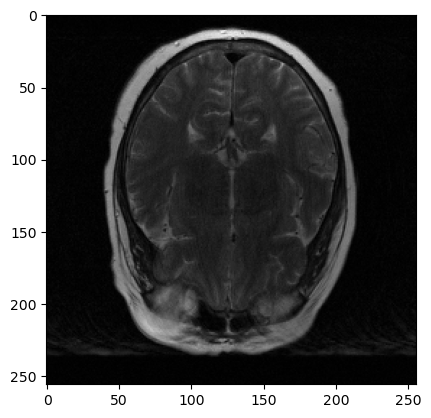

In [26]:
cplx_img = two_channel_img[0,0] + 1j * two_channel_img[0,1]
plt.figure()
plt.imshow(abs(cplx_img),cmap='gray')

121
(2, 256, 256)


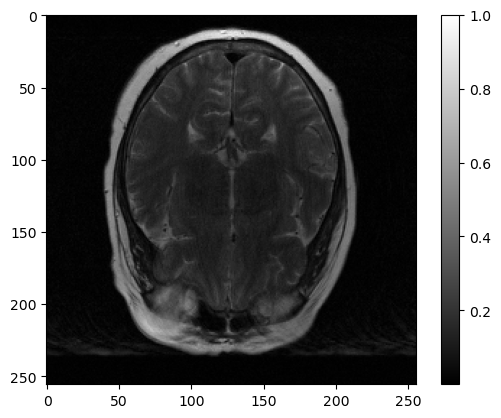

In [33]:
files = glob.glob('/csiNAS2/slow/brett/fastmri_brain_preprocessed_256/*/*/*.npy')
print(len(files))

img = np.load(files[90])
print(img.shape)
cplx_img = img[0] + 1j*img[1]
plt.figure()
plt.imshow(abs(cplx_img), cmap='gray')
plt.colorbar()